In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

#fetching wheat data from yahoo finance
data = yf.Ticker('ZW=F')
data = yf.download('ZW=F', period = 'max')

# Resetting the index to turn the date index into a column
data.reset_index(inplace=True)

data

[*********************100%%**********************]  1 of 1 completed


,Date,Open,High,Low,Close,Adj Close,Volume
0,2000-07-17,248.00,248.00,243.75,244.00,244.00,7233
1,2000-07-18,244.25,247.50,241.00,241.25,241.25,6523
2,2000-07-19,241.25,246.00,239.00,245.00,245.00,7136
3,2000-07-20,244.00,247.50,244.00,247.00,247.00,3792
4,2000-07-21,247.00,248.50,246.50,247.25,247.25,4380
...,...,...,...,...,...,...,...
5899,2024-03-06,519.75,521.25,519.75,521.25,521.25,206
5900,2024-03-07,526.50,526.50,520.75,520.75,520.75,251
5901,2024-03-08,528.50,528.50,526.75,526.75,526.75,15
5902,2024-03-11,526.75,537.50,526.00,537.50,537.50,15


In [2]:
# trim dataset to relevent columns (we only need date and close to forecast prices)
data = data[['Date', 'Close']]
data

,Date,Close
0,2000-07-17,244.00
1,2000-07-18,241.25
2,2000-07-19,245.00
3,2000-07-20,247.00
4,2000-07-21,247.25
...,...,...
5899,2024-03-06,521.25
5900,2024-03-07,520.75
5901,2024-03-08,526.75
5902,2024-03-11,537.50


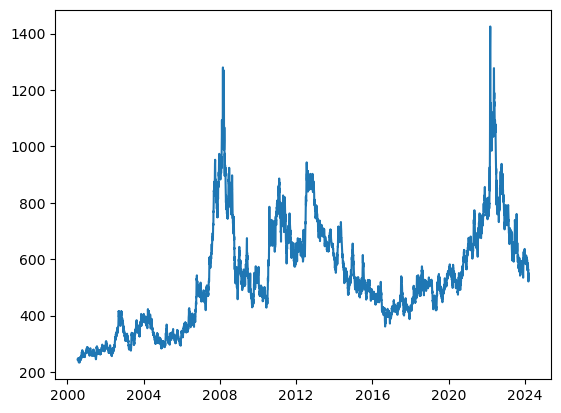

In [3]:
#simple transformations
data.loc[:, 'Date'] = pd.to_datetime(data['Date'])

plt.plot(data['Date'], data['Close'])

In [4]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [5]:
#takes df from above and creates a lookback window of a week (lookback =7) 
from copy import deepcopy as dc

def prepare_dataframe_for_lstm(df, n_steps):
    df = dc(df)
    
    df.set_index('Date', inplace=True)
    
    #shifts dataframe for each lookback window
    for i in range(1, n_steps+1):
        df[f'Close(t-{i})'] = df['Close'].shift(i)
        
    df.dropna(inplace=True)
    
    return df

lookback = 7
shifted_df = prepare_dataframe_for_lstm(data, lookback)
shifted_df

,Close,Close(t-1),Close(t-2),Close(t-3),Close(t-4),Close(t-5),Close(t-6),Close(t-7)
Date,,,,,,,,
2000-07-26,244.25,245.50,245.50,247.25,247.00,245.00,241.25,244.00
2000-07-27,245.75,244.25,245.50,245.50,247.25,247.00,245.00,241.25
2000-07-28,248.50,245.75,244.25,245.50,245.50,247.25,247.00,245.00
2000-07-31,246.00,248.50,245.75,244.25,245.50,245.50,247.25,247.00
2000-08-01,245.00,246.00,248.50,245.75,244.25,245.50,245.50,247.25
...,...,...,...,...,...,...,...,...
2024-03-06,521.25,545.75,563.50,560.00,577.50,571.00,586.00,577.25
2024-03-07,520.75,521.25,545.75,563.50,560.00,577.50,571.00,586.00
2024-03-08,526.75,520.75,521.25,545.75,563.50,560.00,577.50,571.00


In [6]:
shifted_df_as_np = shifted_df.to_numpy()

shifted_df_as_np

array([[244.25, 245.5 , 245.5 , ..., 245.  , 241.25, 244.  ],
       [245.75, 244.25, 245.5 , ..., 247.  , 245.  , 241.25],
       [248.5 , 245.75, 244.25, ..., 247.25, 247.  , 245.  ],
       ...,
       [526.75, 520.75, 521.25, ..., 560.  , 577.5 , 571.  ],
       [537.5 , 526.75, 520.75, ..., 563.5 , 560.  , 577.5 ],
       [549.  , 537.5 , 526.75, ..., 545.75, 563.5 , 560.  ]])

In [7]:
shifted_df_as_np.shape

(5897, 8)

In [8]:
#runs scaler on data
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
shifted_df_as_np = scaler.fit_transform(shifted_df_as_np)

shifted_df_as_np

array([[-0.9819593 , -0.97986155, -0.97986155, ..., -0.98070065,
        -0.98699392, -0.98237885],
       [-0.979442  , -0.9819593 , -0.97986155, ..., -0.97734424,
        -0.98070065, -0.98699392],
       [-0.97482694, -0.979442  , -0.9819593 , ..., -0.97692469,
        -0.97734424, -0.98070065],
       ...,
       [-0.50786658, -0.51793581, -0.51709671, ..., -0.45206629,
        -0.42269771, -0.43360604],
       [-0.48982589, -0.50786658, -0.51793581, ..., -0.44619257,
        -0.45206629, -0.42269771],
       [-0.47052654, -0.48982589, -0.50786658, ..., -0.4759807 ,
        -0.44619257, -0.45206629]])

In [9]:
#changes df into x and y
X = shifted_df_as_np[:, 1:]
y = shifted_df_as_np[:, 0]

X.shape, y.shape

((5897, 7), (5897,))

In [10]:
X = dc(np.flip(X, axis=1))
X

array([[-0.98237885, -0.98699392, -0.98070065, ..., -0.97692469,
        -0.97986155, -0.97986155],
       [-0.98699392, -0.98070065, -0.97734424, ..., -0.97986155,
        -0.97986155, -0.9819593 ],
       [-0.98070065, -0.97734424, -0.97692469, ..., -0.97986155,
        -0.9819593 , -0.979442  ],
       ...,
       [-0.43360604, -0.42269771, -0.45206629, ..., -0.4759807 ,
        -0.51709671, -0.51793581],
       [-0.42269771, -0.45206629, -0.44619257, ..., -0.51709671,
        -0.51793581, -0.50786658],
       [-0.45206629, -0.44619257, -0.4759807 , ..., -0.51793581,
        -0.50786658, -0.48982589]])

In [11]:
#use first 95% as train and last 5% as test
split_index = int(len(X) * 0.95)

split_index

5602

In [12]:
# splitting into train and test
X_train = X[:split_index]
X_test = X[split_index:]

y_train = y[:split_index]
y_test = y[split_index:]

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((5602, 7), (295, 7), (5602,), (295,))

In [13]:
#PyTorch requires an extra dimension at end
X_train = X_train.reshape((-1, lookback, 1))
X_test = X_test.reshape((-1, lookback, 1))

y_train = y_train.reshape((-1, 1))
y_test = y_test.reshape((-1, 1))

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((5602, 7, 1), (295, 7, 1), (5602, 1), (295, 1))

In [14]:
#wrapping in tensors for PyTorch
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).float()

X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([5602, 7, 1]),
 torch.Size([295, 7, 1]),
 torch.Size([5602, 1]),
 torch.Size([295, 1]))

In [15]:
#need datasets object for PyTorch
#needs to be custom class
from torch.utils.data import Dataset

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]
    
train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

In [16]:
train_dataset

In [17]:
# wrap datasets in dataloaders to get batches
# used for iteration
from torch.utils.data import DataLoader

batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [18]:
#gives predicted outputs of arrays
for _, batch in enumerate(train_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)
    print(x_batch.shape, y_batch.shape)
    break

torch.Size([16, 7, 1]) torch.Size([16, 1])


In [19]:
#takes in number of features, dimensions and number of stacked layers (more layers = more complexity in model)
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers
        
        #initally use 1 layer to prevent overfitting in training data
        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers, 
                            batch_first=True)
        
        #maps hidden layer to 1. Needed to predict final closing value
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        batch_size = x.size(0)
        #initialise LSTM with default h0 and c0
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        
        out, _ = self.lstm(x, (h0, c0))
        #output is gotten from passing varibles in fully connected layer
        out = self.fc(out[:, -1, :])
        return out

#initial model has 1 input size, 4 hidden sizes and 1 stacked layer
model = LSTM(1, 4, 1)
model.to(device)
model

LSTM(
  (lstm): LSTM(1, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)

In [20]:
#sets model to training mode
def train_one_epoch():
    model.train(True)
    print(f'Epoch: {epoch + 1}')
    running_loss = 0.0
    
    for batch_index, batch in enumerate(train_loader):
        #puts x and y batch onto device we're using 
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)
        
        output = model(x_batch)
        #comparing model's output to ground truth
        #loss is a tensor with a single value
        loss = loss_function(output, y_batch)
        running_loss += loss.item()
        
        #zero out gradients 
        optimizer.zero_grad()
        #backwards pass 
        loss.backward()
        optimizer.step()

        #every 100 batches get avg loss across batches and print
        if batch_index % 100 == 99:  # print every 100 batches
            avg_loss_across_batches = running_loss / 100
            print('Batch {0}, Loss: {1:.3f}'.format(batch_index+1,
                                                    avg_loss_across_batches))
            running_loss = 0.0
    print()

In [21]:
#sets model to validate mode
def validate_one_epoch():
    model.train(False)
    running_loss = 0.0
    
    for batch_index, batch in enumerate(test_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)
        
        #don't need to calcualte gradient as there's no model updates
        with torch.no_grad():
            output = model(x_batch)
            #compare output to ground truth
            loss = loss_function(output, y_batch)
            running_loss += loss.item()
    #average loss value across all batches
    avg_loss_across_batches = running_loss / len(test_loader)
    
    print('Val Loss: {0:.3f}'.format(avg_loss_across_batches))
    print('***************************************************')
    print()

In [22]:
learning_rate = 0.001
#10 epochs is all that is necessary as any more will cause overfitting
num_epochs = 10
#trying to minimise mean squared error
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    train_one_epoch()
    validate_one_epoch()

Epoch: 1
Batch 100, Loss: 0.162
Batch 200, Loss: 0.044
Batch 300, Loss: 0.011

Val Loss: 0.003
***************************************************

Epoch: 2
Batch 100, Loss: 0.004
Batch 200, Loss: 0.003
Batch 300, Loss: 0.003

Val Loss: 0.002
***************************************************

Epoch: 3
Batch 100, Loss: 0.002
Batch 200, Loss: 0.001
Batch 300, Loss: 0.002

Val Loss: 0.001
***************************************************

Epoch: 4
Batch 100, Loss: 0.001
Batch 200, Loss: 0.001
Batch 300, Loss: 0.001

Val Loss: 0.001
***************************************************

Epoch: 5
Batch 100, Loss: 0.001
Batch 200, Loss: 0.001
Batch 300, Loss: 0.001

Val Loss: 0.001
***************************************************

Epoch: 6
Batch 100, Loss: 0.001
Batch 200, Loss: 0.001
Batch 300, Loss: 0.001

Val Loss: 0.001
***************************************************

Epoch: 7
Batch 100, Loss: 0.001
Batch 200, Loss: 0.001
Batch 300, Loss: 0.001

Val Loss: 0.001
*****************

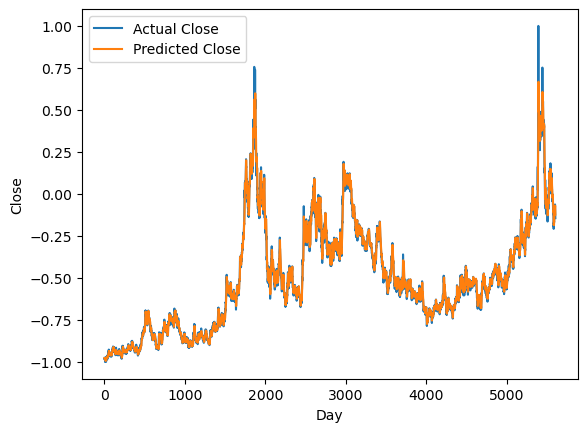

In [23]:
#no gradients for predictions
with torch.no_grad():
    #makes sure it on the device and is put to the CPU (numpy doesn't use GPU)
    predicted = model(X_train.to(device)).to('cpu').numpy()

plt.plot(y_train, label='Actual Close')
plt.plot(predicted, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()

In [24]:
#above data still includes scalar begins at -1
#do opposite of earlier transform
train_predictions = predicted.flatten()

#lookback+1 is the length of the whole dataset
dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:, 0] = train_predictions
dummies = scaler.inverse_transform(dummies)

#return in right scale
train_predictions = dc(dummies[:, 0])
train_predictions

array([246.97337825, 246.62243558, 246.78961372, ..., 783.87021004,
       766.10387531, 756.49151899])

In [25]:
#first column is no y_train.flatter()
dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:, 0] = y_train.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_train = dc(dummies[:, 0])
new_y_train

array([244.25001203, 245.74999802, 248.50000192, ..., 745.49999635,
       746.74999651, 743.5000032 ])

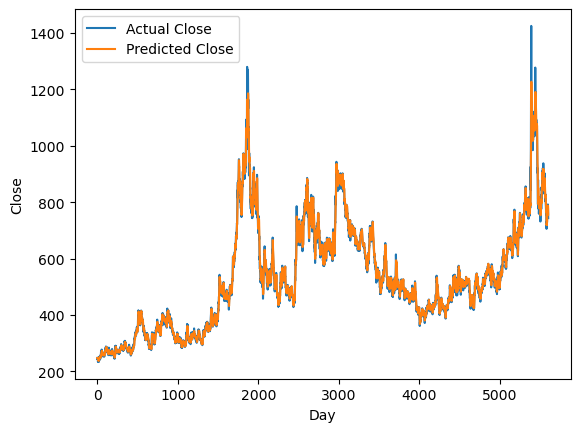

In [26]:
#same graph as earlier with different y_train and predictions
plt.plot(new_y_train, label='Actual Close')
plt.plot(train_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()


In [27]:
#convert to vector of predictions 
test_predictions = model(X_test.to(device)).detach().cpu().numpy().flatten()

dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = test_predictions
dummies = scaler.inverse_transform(dummies)

test_predictions = dc(dummies[:, 0])
test_predictions

array([749.75974452, 745.66990929, 738.6055322 , 739.8687269 ,
       742.37388605, 744.28280495, 749.44770176, 747.63587723,
       742.34216056, 742.63789218, 732.09536998, 733.54771002,
       738.15951075, 746.78628593, 750.36336341, 753.30822201,
       759.12522275, 761.16996277, 762.72468477, 761.25931446,
       757.04891706, 754.29054892, 760.38372477, 760.33037836,
       774.7309879 , 785.90227497, 788.87059249, 781.51431073,
       774.57738611, 770.79251689, 761.1426547 , 749.07262535,
       743.63358233, 725.99844709, 710.21122157, 699.81896257,
       697.81817029, 699.72557084, 698.57857862, 691.5915485 ,
       688.64919385, 681.94181506, 667.79724698, 666.88655769,
       669.88120212, 679.20000668, 692.72053364, 698.29164632,
       706.56259525, 705.48778229, 695.50033624, 679.56300734,
       670.04152549, 678.81875033, 689.32369563, 696.5219715 ,
       702.82486587, 699.47531863, 696.83440494, 695.65549189,
       694.19429038, 688.76254609, 682.55887711, 680.86

In [28]:
#make ground truth proper scale
dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = y_test.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_test = dc(dummies[:, 0])
new_y_test

array([741.50000117, 731.0000016 , 739.99999743, 742.75000133,
       743.74999791, 751.74999716, 742.49999775, 734.4999985 ,
       741.50000117, 720.00000374, 734.4999985 , 741.24999759,
       752.49999903, 749.99999871, 752.49999903, 761.25000015,
       759.75000084, 761.000001  , 756.7499978 , 750.25000229,
       749.750004  , 764.75000149, 757.25000052, 785.99999977,
       792.00000143, 785.99999977, 769.2499994 , 765.00000063,
       765.49999892, 750.499997  , 736.50000053, 738.24999898,
       708.25000401, 695.99999711, 691.50000364, 697.00000257,
       701.25000134, 695.75000241, 682.49999894, 684.74999567,
       674.49999969, 653.50000055, 666.74999514, 672.25000295,
       686.500003  , 702.7499962 , 698.99999572, 710.50000075,
       700.75000305, 683.25000081, 663.50000183, 661.99999809,
       688.49999615, 697.99999915, 699.7499976 , 704.74999824,
       692.24999663, 692.24999663, 693.49999679, 691.50000364,
       682.00000065, 675.49999626, 678.50000375, 673.99

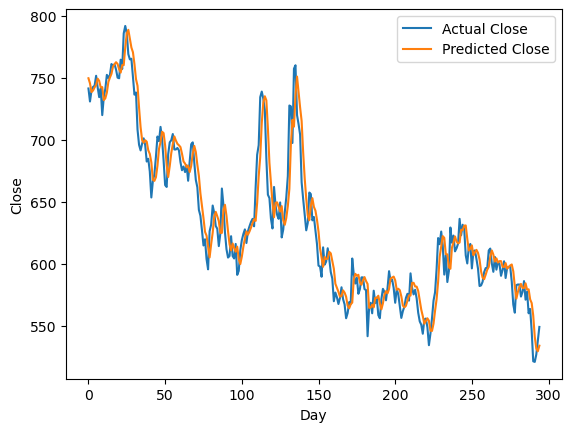

In [29]:
#revised graph with more accurate axises 
plt.plot(new_y_test, label='Actual Close')
plt.plot(test_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()

In [30]:
from math import sqrt
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# For each model, replace `actuals` and `predictions` with the corresponding variables
actuals = new_y_test
predictions = test_predictions

# Calculate the RMSE
rmse = sqrt(mean_squared_error(actuals, predictions))
print("Root Mean Square Error (RMSE):", rmse)

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(actuals, predictions)
print("Mean Absolute Error (MAE):", mae)

# Calculate Mean Absolute Percentage Error (MAPE)
mape = np.mean(np.abs((actuals - predictions) / actuals)) * 100
print("Mean Absolute Percentage Error (MAPE):", mape)


Root Mean Square Error (RMSE): 16.687118519721434
Mean Absolute Error (MAE): 12.829651166230313
Mean Absolute Percentage Error (MAPE): 2.0218892114775713


In [31]:
#comparing the RMSE, MAE and MAPE for Training vs Validation data to check for overfitting
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import torch

def evaluate_model(model, data_loader):
    model.eval()  # Set the model to evaluation mode
    predictions, actuals = [], []
    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            predictions.extend(outputs.view(-1).tolist())
            actuals.extend(targets.view(-1).tolist())

    mse = mean_squared_error(actuals, predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(actuals, predictions)
    mape = np.mean(np.abs((np.array(actuals) - np.array(predictions)) / np.array(actuals))) * 100
    
    return rmse, mae, mape

# Assuming 'train_loader' and 'test_loader' are already defined
# Evaluate the model on training data
train_rmse, train_mae, train_mape = evaluate_model(model, train_loader)
print(f'Training - RMSE: {train_rmse:.3f}, MAE: {train_mae:.3f}, MAPE: {train_mape:.3f}%')

# Evaluate the model on test (validation) data
val_rmse, val_mae, val_mape = evaluate_model(model, test_loader)  # Use test_loader as validation loader
print(f'Validation - RMSE: {val_rmse:.3f}, MAE: {val_mae:.3f}, MAPE: {val_mape:.3f}%')


Training - RMSE: 0.028, MAE: 0.018, MAPE: 17.668%
Validation - RMSE: 0.028, MAE: 0.022, MAPE: 8.052%
